In [1]:
import os

import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Clustering do dataset de baixa tensão

## Variaveis para clustering

In [3]:
# K-Means
NUM_K_MEANS_CLUSTERS = 3

# Hierarquico
NUM_HIERARCHICAL_CLUSTERS = 3

# DBSCAN
DBSCAN_EPSILON = 0.25*1e7
DBSCAN_MIN_SAMPLES = 11

## Importar dataset de baixa tensão númerico

In [4]:
data_path = '../data/' if os.path.exists('../data/') else 'https://raw.githubusercontent.com/kreativermario/Projeto-DECD/master/data/'

low_tensions_df_path = data_path + 'treated/prepared/numeric/no-dates/dataset-numeric-low-tensions-no-dates.csv'

low_tensions_df = pd.read_csv(low_tensions_df_path)

In [5]:
low_tensions_df.info()
low_tensions_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4914 entries, 0 to 4913
Data columns (total 7 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   energia_ativa_baixa_tensao_kwh             4914 non-null   int64
 1   cpes_domestico_baixa_tensao                4914 non-null   int64
 2   cpes_iluminacao_publica_baixa_tensao       4914 non-null   int64
 3   cpes_nao_domestico_baixa_tensao            4914 non-null   int64
 4   cpes_outros_baixa_tensao                   4914 non-null   int64
 5   cpes_mobilidade_eletrica_nao_baixa_tensao  4914 non-null   int64
 6   cpes_mobilidade_eletrica_sim_baixa_tensao  4914 non-null   int64
dtypes: int64(7)
memory usage: 268.9 KB


,energia_ativa_baixa_tensao_kwh,cpes_domestico_baixa_tensao,cpes_iluminacao_publica_baixa_tensao,cpes_nao_domestico_baixa_tensao,cpes_outros_baixa_tensao,cpes_mobilidade_eletrica_nao_baixa_tensao,cpes_mobilidade_eletrica_sim_baixa_tensao
count,4.914000e+03,4914.000000,4914.000000,4914.000000,4914.000000,4914.000000,4914.000000
mean,6.473418e+06,18802.326414,214.084046,4241.061661,128.958079,27020.995319,9.315832
std,1.161919e+07,29402.960918,194.120963,6870.529538,206.186626,45854.018577,24.622134
min,1.390660e+05,1042.000000,7.000000,174.000000,1.000000,1144.000000,0.000000
25%,1.269620e+06,4581.000000,91.000000,1101.000000,21.000000,6044.000000,2.000000
50%,2.618006e+06,8936.000000,141.000000,1989.500000,54.000000,11336.000000,2.000000
75%,7.045592e+06,21427.000000,280.000000,4897.250000,157.000000,29565.500000,6.000000
max,1.633807e+08,312074.000000,1185.000000,79984.000000,2186.000000,528158.000000,382.000000


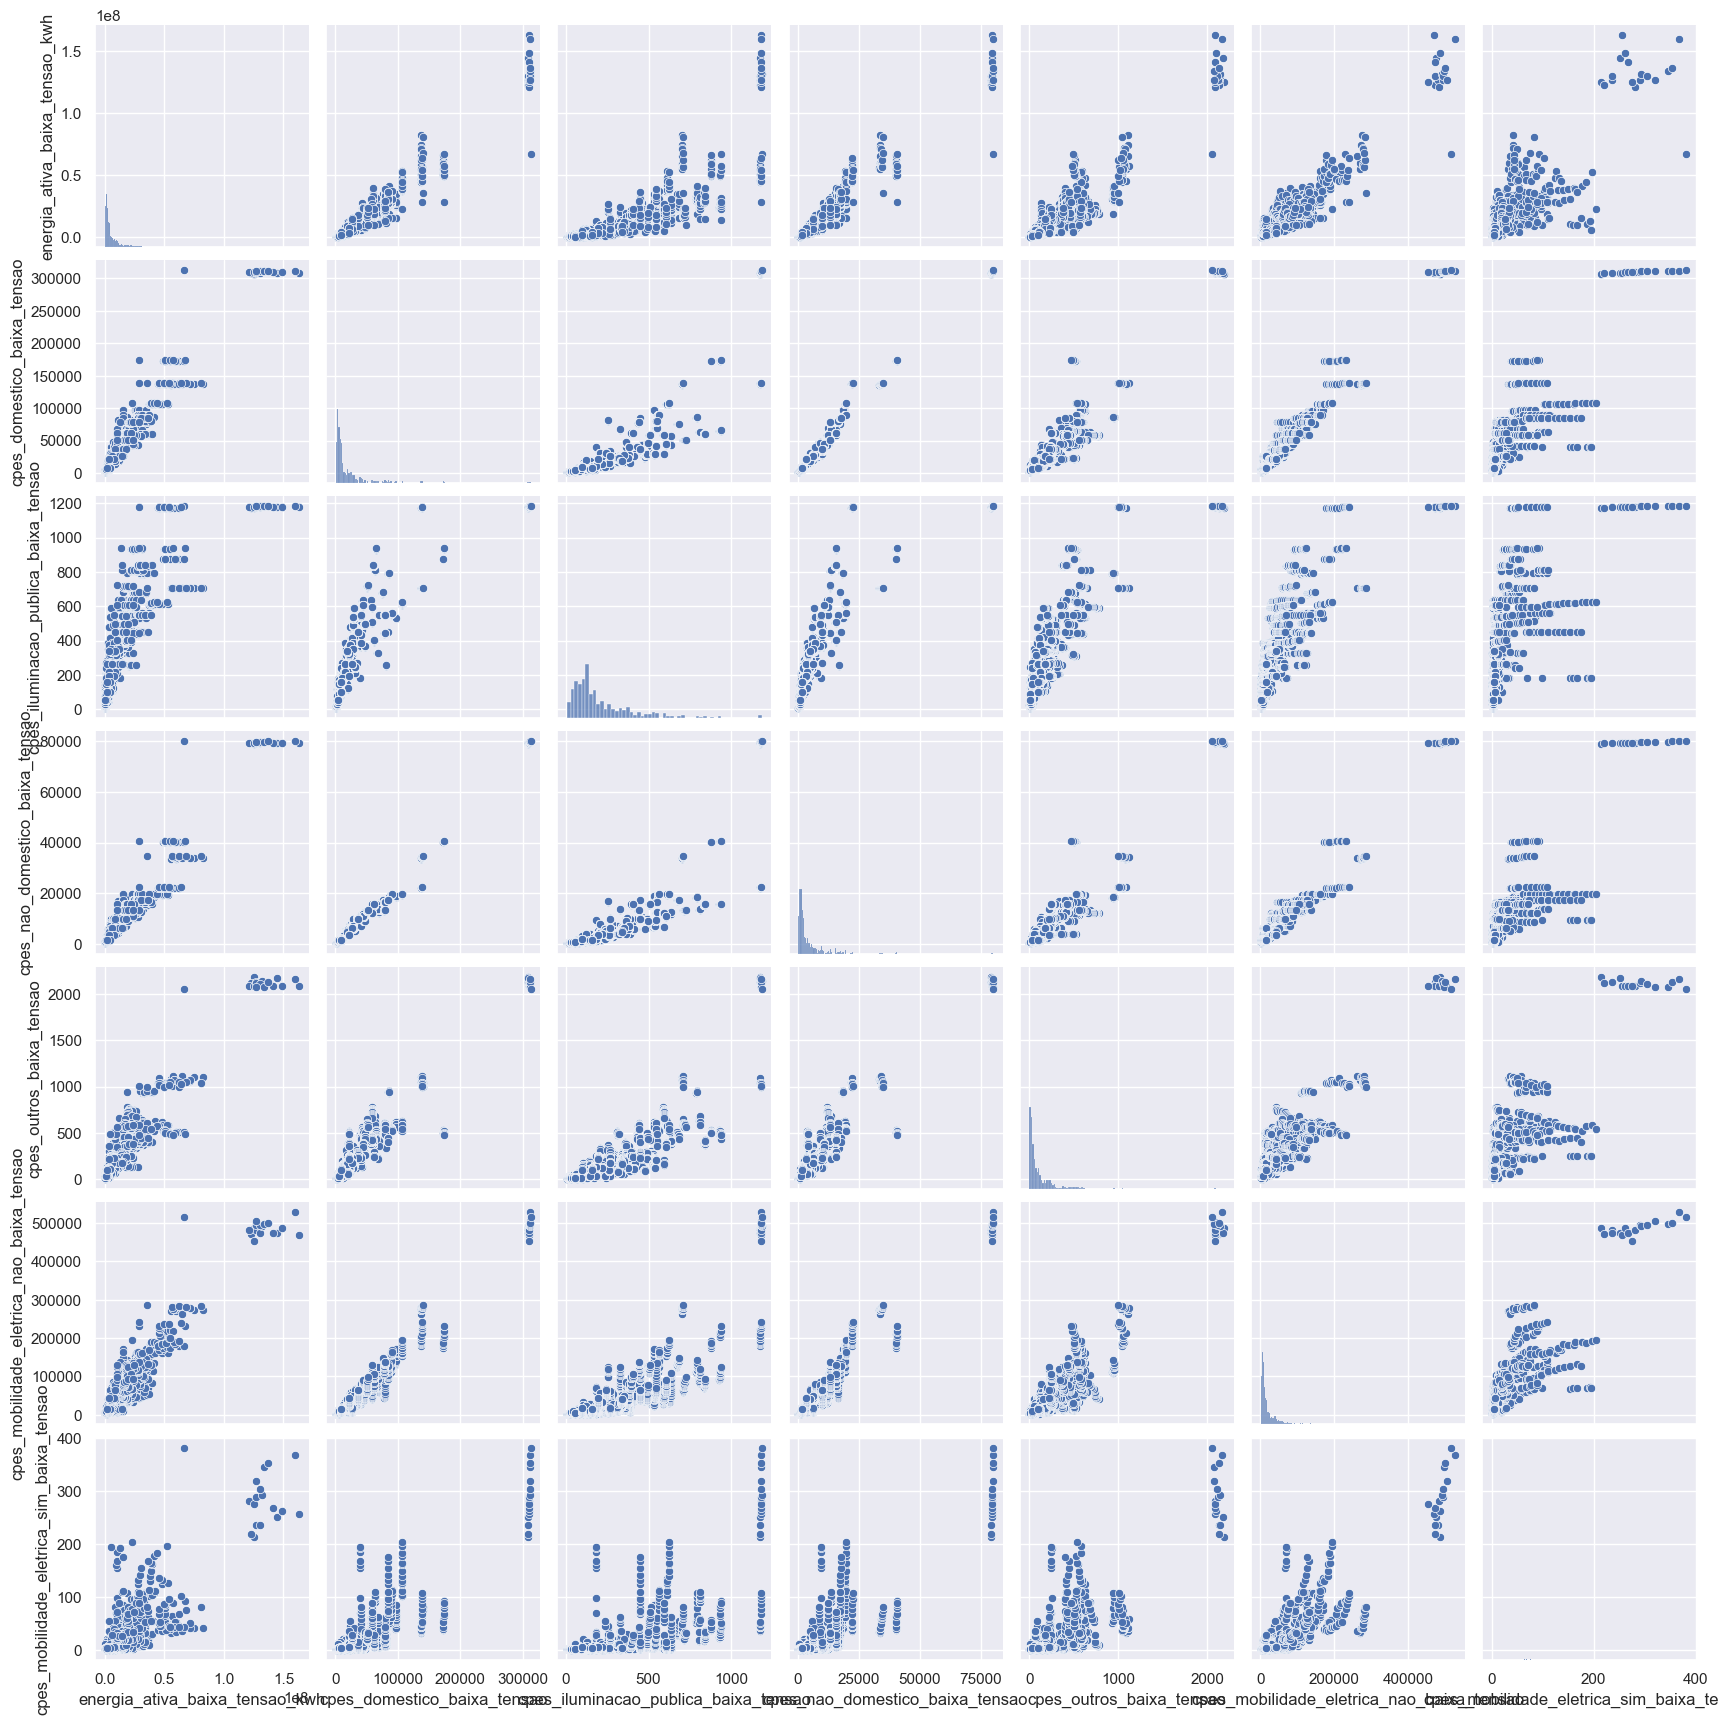

In [6]:
sns.pairplot(low_tensions_df);

## Aplicação do PCA para redução de dimensionalidade

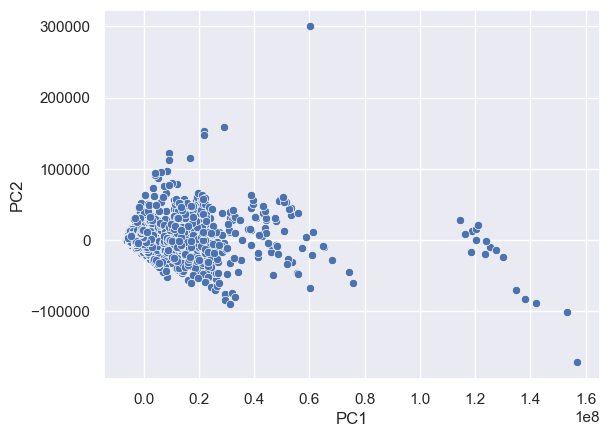

In [7]:
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(low_tensions_df), index=low_tensions_df.index, columns=['PC1', 'PC2'])
sns.scatterplot(pca_df, x='PC1', y='PC2');

### Percentagem da variância do conjunto de dados explicada pelos dois componentes principais.

In [8]:
pca.explained_variance_ratio_.sum()*100

99.99997976469157

# Utilizando o algoritmo de K-Means

## Utilizar o método cotovelo para ver o número ideal de clusters

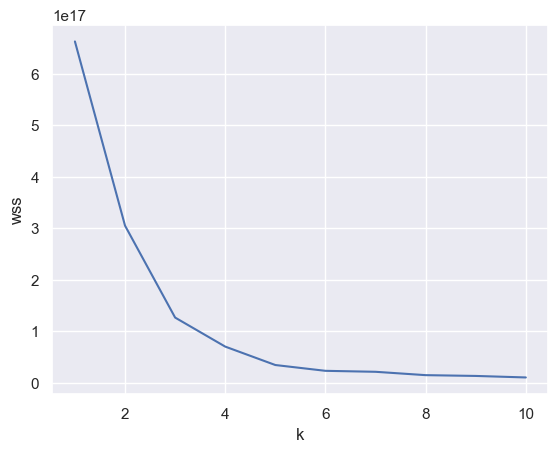

In [9]:
k_wss = pd.DataFrame([(k, KMeans(n_clusters=k, n_init='auto').fit(low_tensions_df).inertia_) for k in range(1, 11)], columns=['k', 'wss'])
sns.lineplot(k_wss, x='k', y='wss');

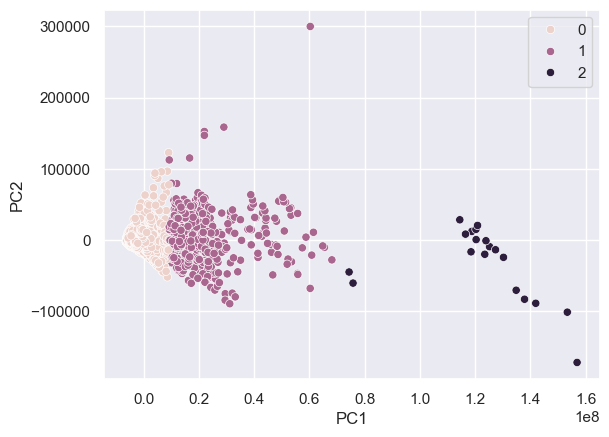

In [10]:
kmeans = KMeans(n_clusters=NUM_K_MEANS_CLUSTERS, n_init='auto').fit(low_tensions_df)
sns.scatterplot(pca_df, x='PC1', y='PC2', hue=kmeans.labels_);

# Utilizando o algoritmo hierárquico aglomerativo

## Criar o dendograma

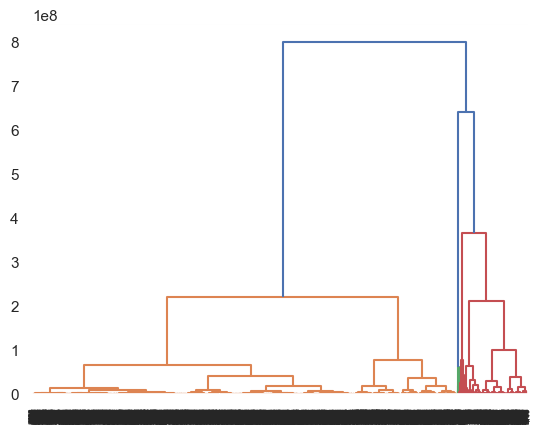

In [11]:
hierarchical_full = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(low_tensions_df)
plot_dendrogram(hierarchical_full)

## Através do dendograma, escolher o número de clusters para o algoritmo hierárquico aglomerativo

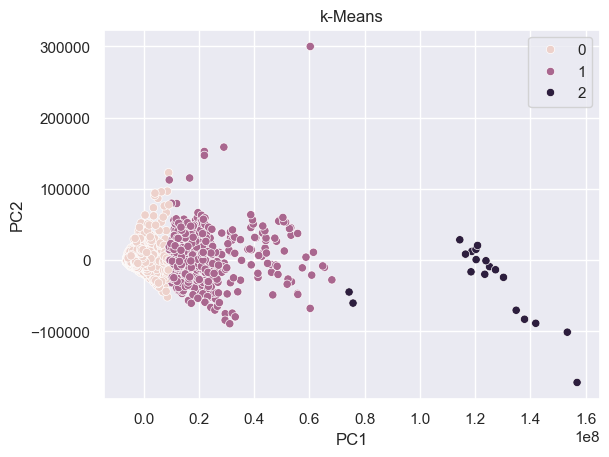

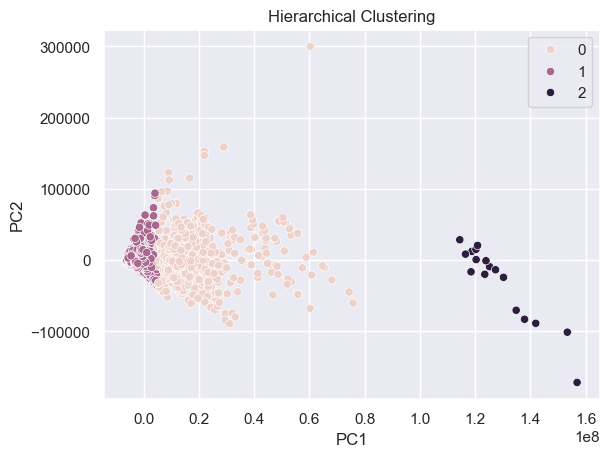

In [12]:
hierarchical_k = AgglomerativeClustering(n_clusters=NUM_HIERARCHICAL_CLUSTERS).fit(low_tensions_df)
sns.scatterplot(pca_df, x='PC1', y='PC2', hue=kmeans.labels_).set(title='k-Means')
plt.show()
sns.scatterplot(pca_df, x='PC1', y='PC2', hue=hierarchical_k.labels_).set(title='Hierarchical Clustering')
plt.show()

# Utilizando o algoritmo DBSCAN

## Determinar o épsilon e minpts

In [13]:
from sklearn.neighbors import NearestNeighbors

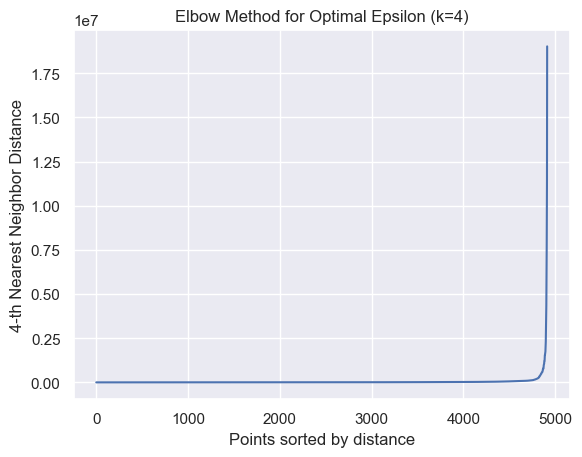

In [14]:
# Calculate the distances to the k nearest neighbors
k = 4  # Choose the number of neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(low_tensions_df) 
distances, indices = neighbors.kneighbors(low_tensions_df)

# Ordenar as distâncias
sorted_distances = np.sort(distances[:, -1])
plt.plot(sorted_distances)

plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title(f'Elbow Method for Optimal Epsilon (k={k})')
plt.grid(True)
plt.show()

Number of clusters: 2
Outliers: 0.5698005698005698%


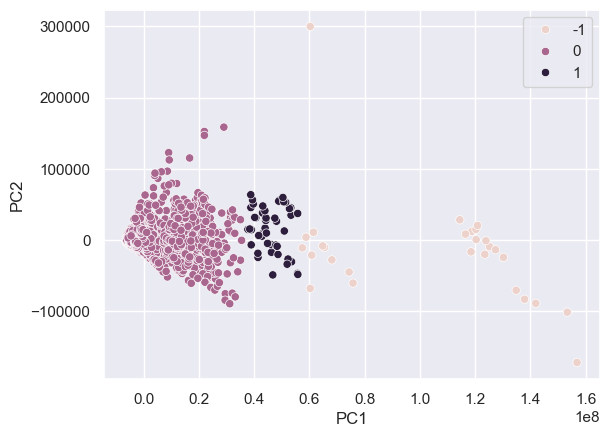

In [15]:
dbscan = DBSCAN(eps=DBSCAN_EPSILON, min_samples=DBSCAN_MIN_SAMPLES).fit(low_tensions_df)
print(f'Number of clusters: {len(set(dbscan.labels_) - {-1})}')
print(f'Outliers: {sum(dbscan.labels_ == -1)*100 / len(dbscan.labels_)}%')
sns.scatterplot(pca_df, x='PC1', y='PC2', hue=dbscan.labels_);

# Escolher o melhor algoritmo de clustering

In [16]:
eval_df = pd.DataFrame(index=['k-Means', 'Hierarchical Clustering', 'DBSCAN'])

# Maior melhor
eval_df['Silhouette Coefficient'] = [sklearn.metrics.silhouette_score(low_tensions_df, c.labels_) for c in (kmeans, hierarchical_k, dbscan)]

# Maior melhor
eval_df['Calinski-Harabasz Index'] = [sklearn.metrics.calinski_harabasz_score(low_tensions_df, c.labels_) for c in (kmeans, hierarchical_k, dbscan)]

# Menor melhor
eval_df['Davies-Bouldin Index'] = [sklearn.metrics.davies_bouldin_score(low_tensions_df, c.labels_) for c in (kmeans, hierarchical_k, dbscan)]

eval_df

,Silhouette Coefficient,Calinski-Harabasz Index,Davies-Bouldin Index
k-Means,0.802314,10431.808730,0.384880
Hierarchical Clustering,0.774841,9411.805779,0.417982
DBSCAN,0.839154,3834.270780,0.524341


# Fazer clustering nos dados normalizados

In [17]:
data_path = '../data/' if os.path.exists('../data/') else 'https://raw.githubusercontent.com/kreativermario/Projeto-DECD/master/data/'

low_tensions_df_normalized_path = data_path + 'treated/prepared/numeric/normalized/dataset-numeric-low-tensions-no-dates-zscore.csv'

low_tensions_normalized_df = pd.read_csv(low_tensions_df_normalized_path)

In [18]:
kmeans_norm = KMeans(n_clusters=NUM_K_MEANS_CLUSTERS, n_init='auto').fit(low_tensions_normalized_df)

print(f'Silhouette Coefficient: {sklearn.metrics.silhouette_score(low_tensions_normalized_df, kmeans_norm.labels_)}')
print(f'Calinski-Harabasz Index: {sklearn.metrics.calinski_harabasz_score(low_tensions_normalized_df, kmeans_norm.labels_)}')
print(f'Davies-Bouldin Index: {sklearn.metrics.davies_bouldin_score(low_tensions_normalized_df, kmeans_norm.labels_)}')

Silhouette Coefficient: 0.7452141681980688
Calinski-Harabasz Index: 7019.780636420805
Davies-Bouldin Index: 0.49859215452647837
